Progress Report 4: Enhanced CNN with Adaptive Denoising and Augmentation for Improved Bounding Box Predictions

Enhanced model complexity with additional layers and enchanced the denosing

In [29]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt

Data Loading and Preprocessing with Diverse Augmentation

In [30]:
BASE_DIR = './new_data/resized_images'
NOISE_FOLDERS = ['high_noise', 'little_noise', 'moderate_noise', 'infared']
annotation_file = os.path.join(BASE_DIR, 'combined_annotations.csv')

def load_data_with_noise(annotation_file, base_dir=BASE_DIR, noise_folders=NOISE_FOLDERS):
    annotations = pd.read_csv(annotation_file)
    images = []
    labels = []
    image_types = []
    source_counts = {folder: 0 for folder in noise_folders}
    source_counts['train_data'] = 0
    source_counts[os.path.basename(base_dir)] = 0  

    for _, row in annotations.iterrows():
        img_filename = row['filename']
        folder_choice = random.choice([base_dir] + [os.path.join(base_dir, folder) for folder in noise_folders])
        img_path = os.path.join(folder_choice, img_filename)
        
        if not os.path.exists(img_path):
            img_path = os.path.join(base_dir, img_filename)
            source_counts['train_data'] += 1
            image_type = 'base'
        else:
            folder_key = os.path.basename(folder_choice)
            source_counts[folder_key] += 1
            image_type = folder_key
        
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            image = cv2.resize(image, (512, 512))
            images.append(image[..., np.newaxis])
            labels.append([row['xmin'] / 512, row['ymin'] / 512, row['xmax'] / 512, row['ymax'] / 512])
            image_types.append(image_type)
    
    print("Data loaded from each source:", source_counts)
    return np.array(images) / 255.0, np.array(labels), image_types

images, labels, image_types = load_data_with_noise(annotation_file)
x_train, x_test, y_train, y_test, train_types, test_types = train_test_split(
    images, labels, image_types, test_size=0.2, random_state=42)

print(f'Training samples: {x_train.shape[0]}, Testing samples: {x_test.shape[0]}')


Data loaded from each source: {'high_noise': 26, 'little_noise': 33, 'moderate_noise': 20, 'infared': 19, 'train_data': 0, 'resized_images': 27}
Training samples: 100, Testing samples: 25


Adaptive Denoising Layer

In [ ]:

denoised_count = tf.Variable(0, trainable=False, dtype=tf.int32)

def adaptive_denoise_layer(inputs):
    @tf.function
    def denoise(image):
        variance = tf.reduce_mean(tf.abs(tf.image.total_variation(image)))

        threshold = variance * 0.8 
        
        smoothing_filter = tf.constant([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype=tf.float32)
        smoothing_filter = smoothing_filter / tf.reduce_sum(smoothing_filter)

        smoothed_image = tf.nn.conv2d(tf.expand_dims(image, 0),
                                      filters=smoothing_filter[..., tf.newaxis, tf.newaxis],
                                      strides=1, padding='SAME')
        smoothed_image = tf.squeeze(smoothed_image, axis=0)

        condition = tf.reduce_any(variance > threshold)
        is_denoised = tf.cast(condition, tf.int32)  # 1 if denoised, 0 if not
        denoised_count.assign_add(is_denoised)  

        
        return tf.where(condition, smoothed_image, image)

    denoised_count.assign(0)

    result = tf.map_fn(denoise, inputs)
    return result


Building and Compiling the Enhanced CNN Model

In [ ]:
def create_model(input_shape=(512, 512, 1)):  
    inputs = Input(shape=input_shape)
    x = Lambda(adaptive_denoise_layer, output_shape=input_shape)(inputs)

    # Convolutional layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)

    
    outputs = Dense(4, activation='linear')(x)

 
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    
    return model


class DenoiseCountCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.total_denoised = 0
        self.total_images = 0

    def on_batch_end(self, batch, logs=None):
       
        batch_size = logs.get("size", 0)
        self.total_images += batch_size
        self.total_denoised += int(denoised_count.numpy())

    def on_epoch_end(self, epoch, logs=None):
        
        print(f"\nEnd of epoch {epoch + 1}: Denoised images = {self.total_denoised}")
        
        self.total_denoised = 0
        self.total_images = 0


model = create_model()

Training the Enhanced Model

In [56]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    zoom_range=0.1,       
    shear_range=0.1       
)

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=10),
    epochs=20,
    validation_data=(x_test, y_test),
    callbacks=[DenoiseCountCallback()]
)

/Users/anthonydibenedetto/opt/anaconda3/envs/MachineLearning/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.1834 - mae: 0.3586
End of epoch 1: Denoised images = 18(0.00%)
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.1825 - mae: 0.3573 - val_loss: 0.0370 - val_mae: 0.1468
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0546 - mae: 0.1831
End of epoch 2: Denoised images = 9(0.00%)
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - loss: 0.0545 - mae: 0.1826 - val_loss: 0.0305 - val_mae: 0.1400
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0341 - mae: 0.1494
End of epoch 3: Denoised images = 13(0.00%)
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 0.0340 - mae: 0.1492 - val_loss: 0.0309 - val_mae: 0.1422
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0358 - mae: 0.1510
End of epoch 4: Denoised images = 9(0.00%)
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 0.0357 - mae: 0.1510 - val_loss: 0.0233 - val_mae: 0.1210
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0302 - mae: 0.1393
End of epoch 5: 

Testing and Enhanced Visualization of Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step


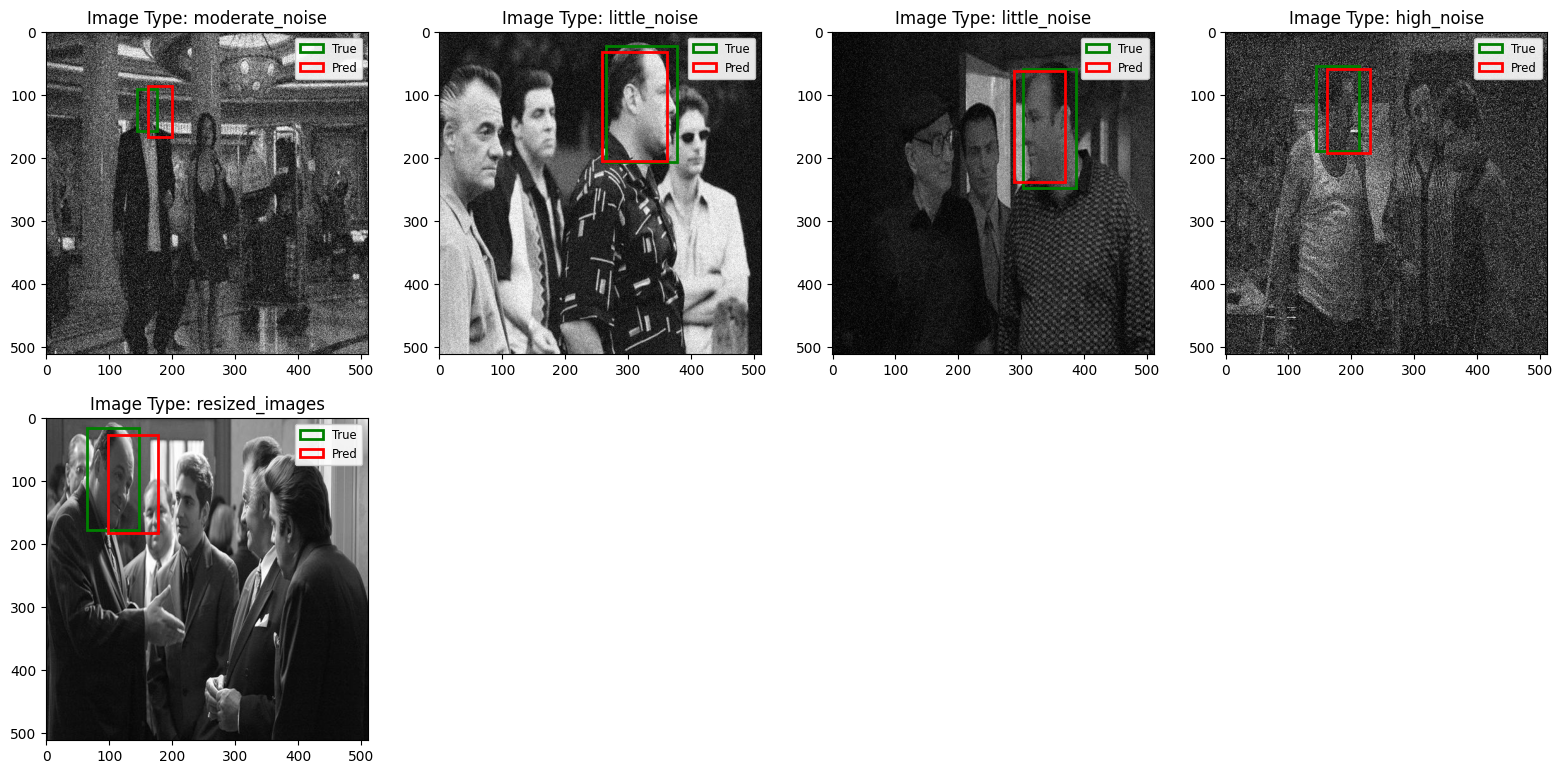

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def visualize_predictions(x_test, y_test, test_types, model, indices=None, show_index=False, max_images_per_row=3):
    preds = model.predict(x_test) * 512  # Scale predictions back to pixel values
    y_test = y_test * 512  # Scale ground truth labels back to pixel values
    
    # Use specified indices if provided, else default to the first 5 indices
    if indices is None:
        indices = range(min(5, len(x_test)))
    
    num_images = len(indices)
    num_rows = (num_images + max_images_per_row - 1) // max_images_per_row  # Calculate required rows
    
    plt.figure(figsize=(max_images_per_row * 4, num_rows * 4))  # Adjust figure size
    
    for i, idx in enumerate(indices):
        if idx >= len(x_test):  # Ensure index is within bounds
            print(f"Index {idx} is out of bounds for x_test with length {len(x_test)}")
            continue

        rgb_image = cv2.cvtColor((x_test[idx] * 255).astype(np.uint8).squeeze(), cv2.COLOR_GRAY2RGB)
        plt.subplot(num_rows, max_images_per_row, i + 1)
        plt.imshow(rgb_image)
        
        # Display title with optional index
        title = f'Image Type: {test_types[idx]}'
        if show_index:
            title = f'Index {idx} - ' + title
        plt.title(title)
        
        # Draw true bounding box (green)
        plt.gca().add_patch(
            plt.Rectangle((y_test[idx][0], y_test[idx][1]), y_test[idx][2] - y_test[idx][0], y_test[idx][3] - y_test[idx][1],
                          edgecolor='g', lw=2, fill=False, label='True')
        )
        
        # Draw predicted bounding box (red)
        plt.gca().add_patch(
            plt.Rectangle((preds[idx][0], preds[idx][1]), preds[idx][2] - preds[idx][0], preds[idx][3] - preds[idx][1],
                          edgecolor='r', lw=2, fill=False, label='Pred')
        )
        
        plt.legend(['True', 'Pred'], loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Example usage with optional flags and max_images_per_row adjustment
visualize_predictions(x_test, y_test, test_types, model, indices=[1,2,3,4,5], show_index=False, max_images_per_row=4)
